In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
sns.set_theme()

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.set_default_dtype(torch.float32)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [8]:
train_dataset = torch.from_numpy(np.load("./Dataset/train_data_5.npy"))
val_dataset = torch.from_numpy(np.load("./Dataset/val_data_5.npy"))
test_dataset = torch.from_numpy(np.load("./Dataset/test_data_5.npy"))

X = train_dataset[:, :-1]
y = train_dataset[:, -1].reshape(-1, 1)

X.shape, y.shape

(torch.Size([19319, 18]), torch.Size([19319, 1]))

In [9]:
from torch.nn import _reduction as _Reduction

class BayesLinear(nn.Module):
    r"""
    Applies Bayesian Linear
    Arguments:
        prior_mu (Float): mean of prior normal distribution.
        prior_sigma (Float): sigma of prior normal distribution.
    .. note:: other arguments are following linear of pytorch 1.2.0.
    https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py
    
    """
    __constants__ = ['prior_mu', 'prior_sigma', 'bias', 'in_features', 'out_features']

    def __init__(self, prior_mu, prior_sigma, in_features, out_features, bias=True):
        super(BayesLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        self.prior_log_sigma = math.log(prior_sigma)
        
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_log_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer('weight_eps', None)
                
        if bias is None or bias is False :
            self.bias = False
        else :
            self.bias = True
            
        if self.bias:
            self.bias_mu = nn.Parameter(torch.Tensor(out_features))
            self.bias_log_sigma = nn.Parameter(torch.Tensor(out_features))
            self.register_buffer('bias_eps', None)
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_log_sigma', None)
            self.register_buffer('bias_eps', None)
            
        self.reset_parameters()

    def reset_parameters(self):
        # Initialization method of Adv-BNN
        stdv = 1. / math.sqrt(self.weight_mu.size(1))
        self.weight_mu.data.uniform_(-stdv, stdv)
        self.weight_log_sigma.data.fill_(self.prior_log_sigma)
        if self.bias :
            self.bias_mu.data.uniform_(-stdv, stdv)
            self.bias_log_sigma.data.fill_(self.prior_log_sigma)
                     
    def forward(self, input):
        if self.weight_eps is None :
            weight = self.weight_mu + torch.exp(self.weight_log_sigma) * torch.randn_like(self.weight_log_sigma)
        else :
            weight = self.weight_mu + torch.exp(self.weight_log_sigma) * self.weight_eps
        
        if self.bias:
            if self.bias_eps is None :
                bias = self.bias_mu + torch.exp(self.bias_log_sigma) * torch.randn_like(self.bias_log_sigma)
            else :
                bias = self.bias_mu + torch.exp(self.bias_log_sigma) * self.bias_eps                
        else :
            bias = None
            
        return F.linear(input, weight, bias)

    def extra_repr(self):
        return 'prior_mu={}, prior_sigma={}, in_features={}, out_features={}, bias={}'.format(self.prior_mu, self.prior_sigma, self.in_features, self.out_features, self.bias is not None)

# Some Loss    
def _kl_loss(mu_0, log_sigma_0, mu_1, log_sigma_1) :
    """
    An method for calculating KL divergence between two Normal distribtuion.
    Arguments:
        mu_0 (Float) : mean of normal distribution.
        log_sigma_0 (Float): log(standard deviation of normal distribution).
        mu_1 (Float): mean of normal distribution.
        log_sigma_1 (Float): log(standard deviation of normal distribution).
   
    """
    kl = log_sigma_1 - log_sigma_0 + \
    (torch.exp(log_sigma_0)**2 + (mu_0-mu_1)**2)/(2*math.exp(log_sigma_1)**2) - 0.5
    return kl.sum()
    
    
# Bayesian KL Loss
def bayesian_kl_loss(model, reduction='mean', last_layer_only=False) :
    """
    An method for calculating KL divergence of whole layers in the model.
    Arguments:
        model (nn.Module): a model to be calculated for KL-divergence.
        reduction (string, optional): Specifies the reduction to apply to the output:
            ``'mean'``: the sum of the output will be divided by the number of
            elements of the output.
            ``'sum'``: the output will be summed.
        last_layer_only (Bool): True for return only the last layer's KL divergence.    
        
    """
    device = torch.device("cuda" if next(model.parameters()).is_cuda else "cpu")
    kl = torch.Tensor([0]).to(device)
    kl_sum = torch.Tensor([0]).to(device)
    n = torch.Tensor([0]).to(device)

    for m in model.modules() :
        if isinstance(m, BayesLinear):
            kl = _kl_loss(m.weight_mu, m.weight_log_sigma, m.prior_mu, m.prior_log_sigma)
            kl_sum += kl
            n += len(m.weight_mu.view(-1))

            if m.bias :
                kl = _kl_loss(m.bias_mu, m.bias_log_sigma, m.prior_mu, m.prior_log_sigma)
                kl_sum += kl
                n += len(m.bias_mu.view(-1))

#         if isinstance(m, BayesBatchNorm2d):
#             if m.affine :
#                 kl = _kl_loss(m.weight_mu, m.weight_log_sigma, m.prior_mu, m.prior_log_sigma)
#                 kl_sum += kl
#                 n += len(m.weight_mu.view(-1))

#                 kl = _kl_loss(m.bias_mu, m.bias_log_sigma, m.prior_mu, m.prior_log_sigma)
#                 kl_sum += kl                
#                 n += len(m.bias_mu.view(-1))
            
    if last_layer_only or n == 0 :
        return kl
    
    if reduction == 'mean' :
        return kl_sum/n
    elif reduction == 'sum' :
        return kl_sum
    else :
        raise ValueError(reduction + " is not valid")    
    
    
# Loss Function
class _Loss(nn.Module):
    def __init__(self, reduction='mean'):
        super(_Loss, self).__init__()
        self.reduction = reduction
            
# KL Loss
class BKLLoss(_Loss):
    """
    Loss for calculating KL divergence of baysian neural network model.
    Arguments:
        reduction (string, optional): Specifies the reduction to apply to the output:
            ``'mean'``: the sum of the output will be divided by the number of
            elements of the output.
            ``'sum'``: the output will be summed.
        last_layer_only (Bool): True for return only the last layer's KL divergence.    
    """
    __constants__ = ['reduction']

    def __init__(self, reduction='mean', last_layer_only=False):
        super(BKLLoss, self).__init__(reduction)
        self.last_layer_only = last_layer_only

    def forward(self, model):
        """
        Arguments:
            model (nn.Module): a model to be calculated for KL-divergence.
        """
        return bayesian_kl_loss(model, reduction=self.reduction, last_layer_only=self.last_layer_only)

In [10]:
# BayesNN 
model = nn.Sequential(
    BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=18, out_features=256),
    nn.PReLU(),
    BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=256, out_features=1),
)

X = X.to(device)
y = y.to(device)
model.to(device)

mse_loss = nn.MSELoss()
kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
optimizer = optim.AdamW(model.parameters(), lr=0.01)

In [11]:
kl_weight = 0.1

for step in range(12_000):
    pred = model(X)
    mse = mse_loss(pred, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 0.12, KL : 0.21


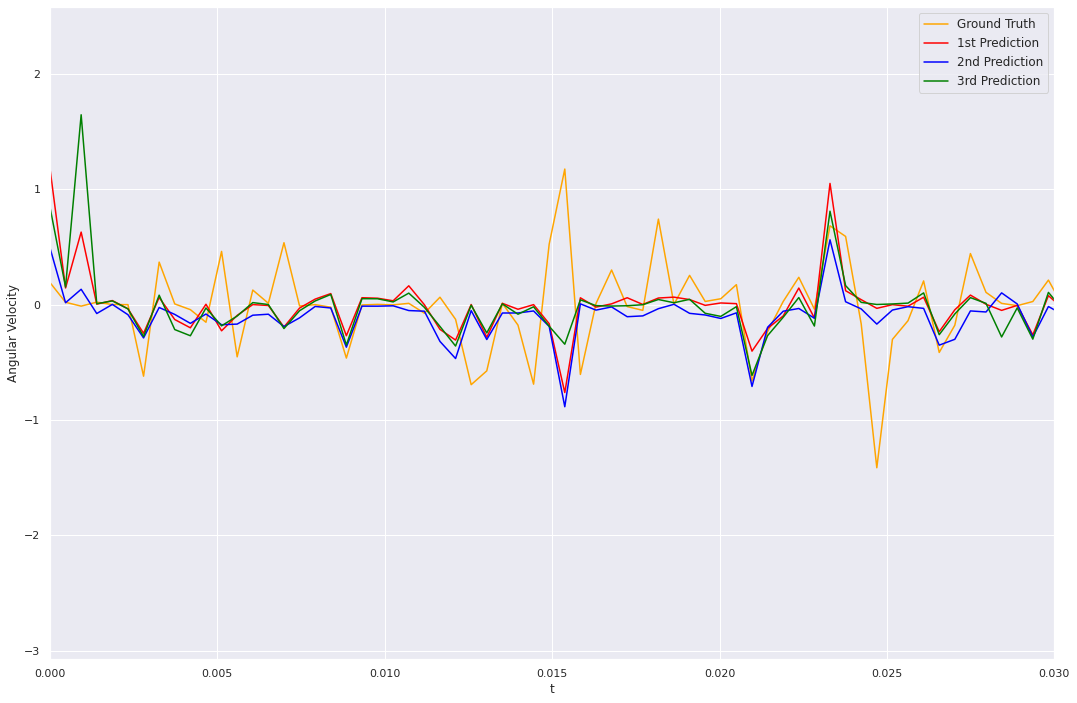

In [12]:
X_val = val_dataset[:, :-1]
y_val = val_dataset[:, -1].reshape(-1, 1)

X_val = X_val.to(device)

t = np.linspace(0, 1, X_val.shape[0])

plt.figure( figsize=(18, 12))
plt.plot(t, y_val.cpu().numpy(), label="Ground Truth", color="Orange")

# First Pred
with torch.no_grad():
    val_pred = model(X_val)
plt.plot(t, val_pred.cpu().numpy(), label="1st Prediction", color="red")

# Second Pred
with torch.no_grad():
    val_pred = model(X_val)
plt.plot(t, val_pred.cpu().numpy(), label="2nd Prediction", color="blue")

# Third Pred
with torch.no_grad():
    val_pred = model(X_val)
plt.plot(t, val_pred.cpu().numpy(), label="3rd Prediction", color="green")

plt.legend(loc=1 ,prop={'size': 12})
plt.xlim(0, 0.03)
# plt.ylim(-10, 10)
plt.xlabel("t")
plt.ylabel("Angular Velocity")
# plt.savefig("GRU Predictions.png")
plt.show()